<h2>Read in latest HRRR dataset using Siphon query and write local netCDF file</h2>

In [32]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Resolve the latest HRRR dataset
from siphon.catalog import TDSCatalog
latest_hrrr = TDSCatalog('http://thredds-jumbo.unidata.ucar.edu/thredds/catalog/grib/HRRR/CONUS_3km/surface/latest.xml')
hrrr_ds = list(latest_hrrr.datasets.values())[0]

# Set up access via NCSS
from siphon.ncss import NCSS
ncss = NCSS(hrrr_ds.access_urls['NetcdfSubset'])

# Create a query to ask for all times in netcdf4 format for
# the Temperature_surface variable, with a bounding box
query = ncss.query()
dap_url = hrrr_ds.access_urls['OPENDAP']

query.all_times().accept('netcdf4').variables('u-component_of_wind_height_above_ground',
                                              'v-component_of_wind_height_above_ground')
query.lonlat_box(45, 41., -63, -71.5)

# Get the raw bytes and write to a file.
data = ncss.get_data_raw(query)
with open('test_uv.nc', 'wb') as outf:
    outf.write(data)

<h2>Read the netCDF file back in</h2>

In [33]:
import xray
nc = xray.open_dataset('test_uv.nc')
nc

<xray.Dataset>
Dimensions:                                  (height_above_ground5: 2, time1: 66, x: 223, y: 216)
Coordinates:
  * time1                                    (time1) datetime64[ns] 2015-07-24T11:00:00 ...
  * height_above_ground5                     (height_above_ground5) float32 10.0 ...
  * y                                        (y) float32 584.694 587.694 ...
  * x                                        (x) float32 2030.43 2033.43 ...
Data variables:
    u-component_of_wind_height_above_ground  (time1, height_above_ground5, y, x) float32 0.395565 ...
    LambertConformal_Projection              int32 0
    v-component_of_wind_height_above_ground  (time1, height_above_ground5, y, x) float32 -0.439932 ...
Attributes:
    Originating_or_generating_Center: The NOAA Forecast Systems Laboratory, Boulder, CO, United States
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Conventions: CF-1.6
    history: Read 

In [39]:
uvar_name='u-component_of_wind_height_above_ground'
vvar_name='v-component_of_wind_height_above_ground'
uvar = nc[uvar_name]
vvar = nc[vvar_name]
grid = nc[uvar.grid_mapping]
grid

<xray.DataArray u'LambertConformal_Projection' ()>
array(0)
Attributes:
    grid_mapping_name: lambert_conformal_conic
    latitude_of_projection_origin: 38.5
    longitude_of_central_meridian: 262.5
    standard_parallel: 38.5
    earth_radius: 6371229.0
    _CoordinateTransformType: Projection
    _CoordinateAxisTypes: GeoX GeoY

In [40]:
uvar

<xray.DataArray 'u-component_of_wind_height_above_ground' (time1: 66, height_above_ground5: 2, y: 216, x: 223)>
[6358176 values with dtype=float32]
Coordinates:
  * height_above_ground5  (height_above_ground5) float32 10.0 80.0
  * time1                 (time1) datetime64[ns] 2015-07-24T11:00:00 ...
  * y                     (y) float32 584.694 587.694 590.694 593.694 ...
  * x                     (x) float32 2030.43 2033.43 2036.43 2039.43 ...
Attributes:
    long_name: u-component of wind @ Specified height level above ground
    units: m/s
    description: u-component of wind
    grid_mapping: LambertConformal_Projection
    Grib_Variable_Id: VAR_0-2-2_L103
    Grib2_Parameter: [0 2 2]
    Grib2_Parameter_Discipline: Meteorological products
    Grib2_Parameter_Category: Momentum
    Grib2_Parameter_Name: u-component of wind
    Grib2_Level_Type: Specified height level above ground
    Grib2_Generating_Process_Type: Forecast

In [34]:
lon0 = grid.longitude_of_central_meridian
lat0 = grid.latitude_of_projection_origin
lat1 = grid.standard_parallel
earth_radius = grid.earth_radius

<h2>Plot Lambert Conformal with Cartopy</h2>

In [41]:
import cartopy
import cartopy.crs as ccrs
#cartopy wants meters, not km
x = uvar.x.data*1000.
y = uvar.y.data*1000.

#globe = ccrs.Globe(ellipse='WGS84') #default
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=grid.earth_radius)

crs = ccrs.LambertConformal(central_longitude=lon0, central_latitude=lat0, 
                            standard_parallels=(lat0,lat1), globe=globe)
print(uvar.x.data.shape)
print(uvar.y.data.shape)
print(uvar.time1.shape)

(223,)
(216,)
(66,)


In [44]:
uvar[-1,:,:].time1.data


numpy.datetime64('2015-07-24T20:00:00.000000000-0400')

In [45]:
klev = 0
u = uvar[istep,klev,:,:].data
v = vvar[istep,klev,:,:].data
spd = np.sqrt(u*u+v*v)

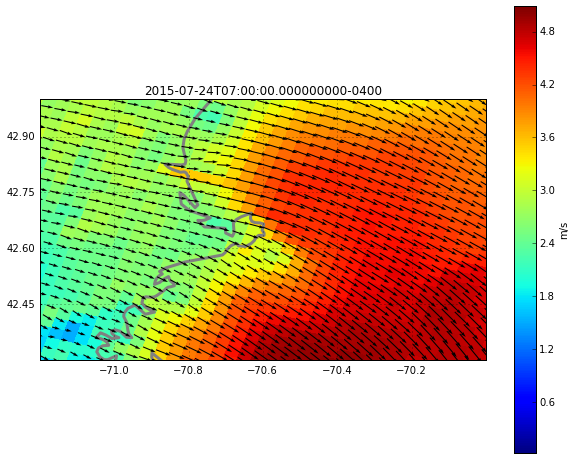

In [46]:
fig = plt.figure(figsize=(10,16))
ax = plt.axes(projection=ccrs.PlateCarree())
c = ax.pcolormesh(x,y,spd, transform=crs,zorder=0)
cb = fig.colorbar(c,orientation='vertical',shrink=0.5)
cb.set_label('m/s')
ax.coastlines(resolution='10m',color='gray',zorder=1,linewidth=3)
ax.quiver(x,y,u,v,transform=crs,zorder=2,scale=100)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title(uvar[istep].time1.data);
plt.axis([-71.2, -70., 42.3, 43])
#plt.axis([-72,-69.8,40.6, 43.5]);